# Installing requirements

In [1]:
!pip install git+https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git to /tmp/pip-req-build-1t5ll65e
  Running command git clone --filter=blob:none --quiet https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git /tmp/pip-req-build-1t5ll65e
  Resolved https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git to commit 4f02dacad9a6d14a3ff2fd35a344b1cac2d75323
  Preparing metadata (setup.py) ... done
  Created wheel for src: filename=src-0.1.0-py3-none-any.whl size=2895 sha256=da8a7feb7009d2039877f32ff43caa2ff1a33f92fd244c43940848810c0b3f45
  Stored in directory: /tmp/pip-ephem-wheel-cache-cpiba5kc/wheels/05/26/e4/331bb032dbc294e55b1e141b7a6595a14c0e57d6c05184dc51
Successfully built src


In [2]:
!pip install pytorch-lightning
!pip install pytorch-toolbelt
!pip install imagecodecs
!pip install stardist
!pip install wandb
!pip install gputools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 7.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 30.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-p

# Imports

In [7]:
from __future__ import annotations

from os import listdir

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import wandb
from csbdeep.utils import normalize
from google.colab import drive
from stardist import calculate_extents
from stardist.models import Config2D
from stardist.models import StarDist2D
from stardist.plot import render_label

# Mounting Google Drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Logging in to Wandb

In [3]:
wandb.login()

wandb: Currently logged in as: maria_wyrzykowska (cirglaboratory). Use `wandb login --relogin` to force relogin


True

# Loading data

In [4]:
PATH = '/content/drive/MyDrive/Cell_segmentation'
files_names =  listdir(f'{PATH}/train/img')
train_imgs = [imageio.imread(f'{PATH}/train/img/{f}') for f in files_names]
train_masks = [imageio.imread(f'{PATH}/train/mask/{f}') for f in files_names]

train_imgs = [normalize(img) if len(img.shape) == 2 else normalize(img[:, :, 0]) for img in train_imgs]
train_masks = [img.astype(int) if len(img.shape) == 2 else img[:, :, 0].astype(int) for img in train_masks]

files_names =  listdir(f'{PATH}/val/img')
val_imgs = [imageio.imread(f'{PATH}/val/img/{f}') for f in files_names]
val_masks = [imageio.imread(f'{PATH}/val/mask/{f}') for f in files_names]

val_imgs = [normalize(img) if len(img.shape) == 2 else normalize(img[:, :, 0]) for img in val_imgs]
val_masks = [img.astype(int) if len(img.shape) == 2 else img[:, :, 0].astype(int) for img in val_masks]

files_names =  listdir(f'{PATH}/test/img')
test_imgs = [imageio.imread(f'{PATH}/test/img/{f}') for f in files_names]
test_masks = [imageio.imread(f'{PATH}/test/mask/{f}') for f in files_names]

test_imgs = [normalize(img) if len(img.shape) == 2 else normalize(img[:, :, 0]) for img in test_imgs]
test_masks = [img.astype(int) if len(img.shape) == 2 else img[:, :, 0].astype(int) for img in test_masks]

# Loading pretrained model

In [7]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
5320433/5320433 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


1/1 [==============================] - 0s 37ms/step


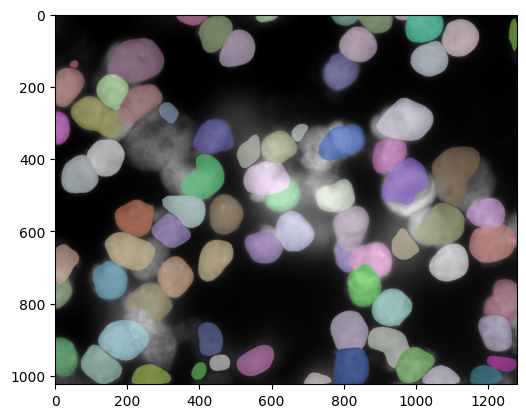

In [9]:
example_pred = model.predict_instances(val_imgs[0])
plt.imshow(render_label(example_pred[0], val_imgs[0]))

# Finetuning pretrained model

In [10]:
model.train(train_imgs, train_masks, validation_data=(val_imgs, val_masks), augmenter=None, epochs=10, steps_per_epoch=30)

Epoch 1/10


Cause: Unable to locate the source code of <function _gcd_import at 0x7fba35453400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7fba35453400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
30/30 [==============================] - 37s 730ms/step - loss: 1.7016 - prob_loss: 0.2193 - dist_loss: 7.4113 - prob_kld: 0.0582 - dist_relevant_mae: 7.4099 - dist_relevant_mse: 371.2768 - dist_dist_iou_metric: 0.7879 - val_loss: 2.3131 - val_prob_loss: 0.3210 - val_dist_loss: 9.9608 - val_prob_kld: 0.0461 - val_dist_relevant_mae: 9.9585 - val_dist_relevant_mse: 388.5794 - val_dist_dist_iou_metric: 0.7156 - lr: 3.0000e-04
Epoch 2/10
30/30 [==============================] - 1

In [11]:
model.optimize_thresholds(val_imgs, val_masks)

1/1 [==============================] - 0s 22ms/step


NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:29<00:09,  1.99s/it, 0.549 -> 0.785]


Using optimized values: prob_thresh=0.599341, nms_thresh=0.3.


{'prob': 0.5993414468566466, 'nms': 0.3}

1/1 [==============================] - 0s 49ms/step


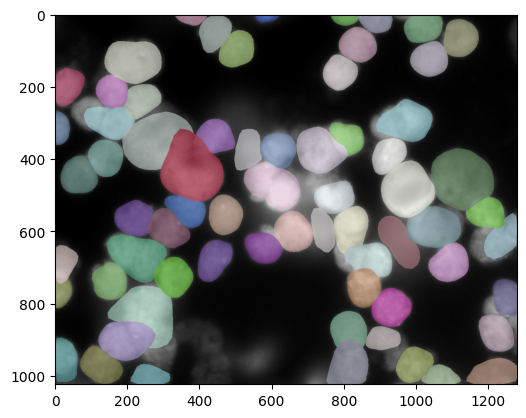

In [16]:
example_pred = model.predict_instances(val_imgs[0])
plt.imshow(render_label(example_pred[0], val_imgs[0]))

In [23]:
median_size = calculate_extents(list(train_masks), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [114. 116.]
network field of view :  [94 94]


# Training model from scratch

In [22]:
# TODO: Try using augmentions

def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [30]:
conf = Config2D (
    use_gpu = False,
    n_channel_in = 1,
    n_rays=32,
    unet_n_depth=3,
    grid=(4,4)
)
model = StarDist2D(conf, name='stardist', basedir='models')
model.train(train_imgs, train_masks, validation_data=(val_imgs, val_masks), augmenter=None, epochs=200, steps_per_epoch=200)
model.optimize_thresholds(val_imgs, val_masks)

Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.521999, nms_thresh=0.3.
Epoch 1/200
200/200 [==============================] - 30s 108ms/step - loss: 6.5062 - prob_loss: 0.5657 - dist_loss: 29.7026 - prob_kld: 0.3991 - dist_relevant_mae: 29.7005 - dist_relevant_mse: 1726.0465 - dist_dist_iou_metric: 0.2505 - val_loss: 5.3747 - val_prob_loss: 0.5413 - val_dist_loss: 24.1672 - val_prob_kld: 0.3447 - val_dist_relevant_mae: 24.1654 - val_dist_relevant_mse: 1382.2562 - val_dist_dist_iou_metric: 0.3241 - lr: 3.0000e-04
Epoch 2/200
200/200 [==============================] - 18s 89ms/step - loss: 3.4980 - prob_loss: 0.2765 - dist_loss: 16.1076 - prob_kld: 0.1105 - dist_relevant_mae: 16.1057 - dist_relevant_mse: 596.0258 - dist_dist_iou_metric: 0.4878 - val_loss: 3.4103 - val_prob_loss: 0.2669 - val_dist_loss: 15.7174 - val_prob_kld: 0.0702 - val_dist_relevant_mae: 15.7159 - val_dist_relevant_mse: 694.7204 - val_dist_dist_iou_metric: 0.4933 - lr: 3.0000e-04
Epoch 

NMS threshold = 0.5:  80%|████████  | 16/20 [00:12<00:03,  1.31it/s, 0.445 -> 0.871]


Using optimized values: prob_thresh=0.443998, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.44399842495597985, 'nms': 0.3}

1/1 [==============================] - 0s 109ms/step


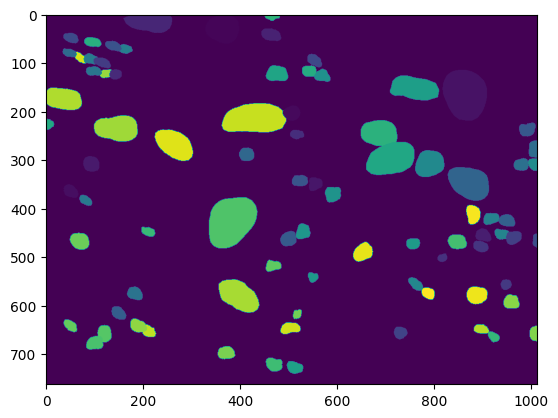

In [45]:
i = 0
example_pred = model.predict_instances(test_imgs[i])
plt.imshow(example_pred[0])

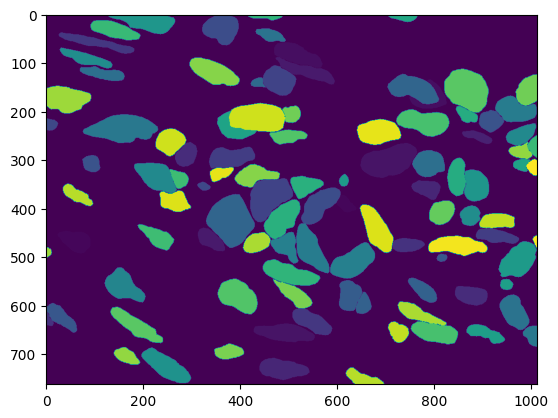

In [46]:
plt.imshow(test_masks[i])